## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
import numpy as np

from data import plot_raw_transfomed_examples, split_dataset, transform_to_tensor, transform_crop_and_resize, transform_res_net_18
from model import PneumoniaDetectionResNetModel
from trainer import Trainer
from datetime import datetime

## 2. Dataset

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [2]:
train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
validation_set = torchvision.datasets.ImageFolder(root="data/val", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
merged_dataset = ConcatDataset([train_set, validation_set])
train_set, validation_set = split_dataset(merged_dataset, 0.7)

test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))

classes = test_set.classes
print(f"Classes: {test_set.class_to_idx}")

Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


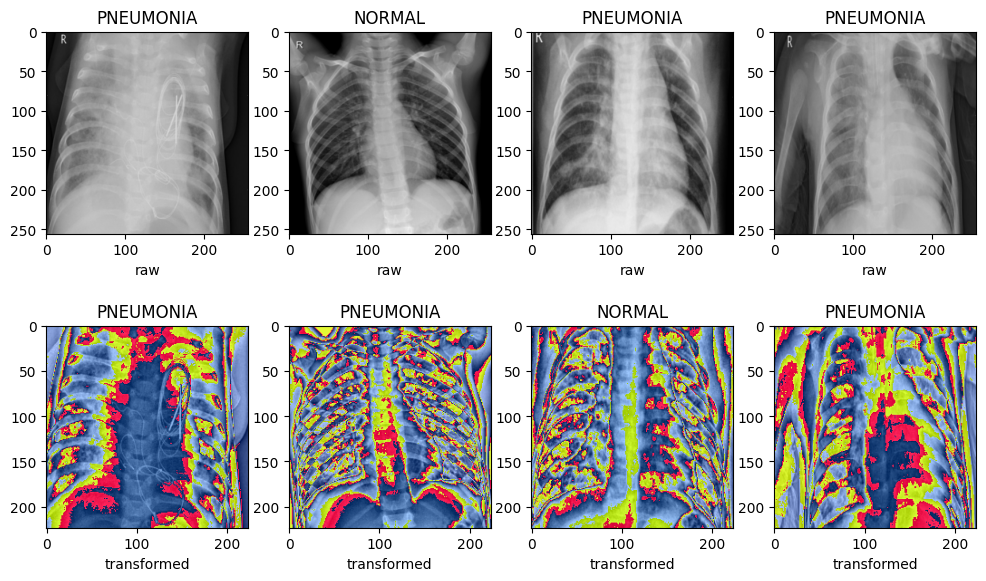

In [3]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
validation_loader = DataLoader(validation_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

plot_raw_transfomed_examples(train_loader, classes, transform_res_net_18)

## 3. Model

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = PneumoniaDetectionResNetModel()
print(model)

PneumoniaDetectionResNetModel(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## 4. Train

In [5]:
adam_optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=3)

In [6]:
trainer.fit()

Epoch [1/3], Step [0/115], Loss: 0.5654
Epoch [1/3], Step [10/115], Loss: 0.4444
Epoch [1/3], Step [20/115], Loss: 0.3000
Epoch [1/3], Step [30/115], Loss: 0.2697
Epoch [1/3], Step [40/115], Loss: 0.3815
Epoch [1/3], Step [50/115], Loss: 0.2703
Epoch [1/3], Step [60/115], Loss: 0.1960
Epoch [1/3], Step [70/115], Loss: 0.1535
Epoch [1/3], Step [80/115], Loss: 0.1339
Epoch [1/3], Step [90/115], Loss: 0.2806
Epoch [1/3], Step [100/115], Loss: 0.0955
Epoch [1/3], Step [110/115], Loss: 0.0806
Epoch [1/3], Validation Loss: 0.1132
Epoch [2/3], Step [0/115], Loss: 0.0975
Epoch [2/3], Step [10/115], Loss: 0.1113
Epoch [2/3], Step [20/115], Loss: 0.1055
Epoch [2/3], Step [30/115], Loss: 0.0807
Epoch [2/3], Step [40/115], Loss: 0.0761
Epoch [2/3], Step [50/115], Loss: 0.0309
Epoch [2/3], Step [60/115], Loss: 0.2137
Epoch [2/3], Step [70/115], Loss: 0.1341
Epoch [2/3], Step [80/115], Loss: 0.0555
Epoch [2/3], Step [90/115], Loss: 0.1513
Epoch [2/3], Step [100/115], Loss: 0.0512
Epoch [2/3], Step [

## 5. Evaluation

Train accuracy: 0.9983615279197693
Train f1 score: 0.9983615279197693
Validation accuracy: 0.9808917045593262
Validation f1 score: 0.9808917045593262


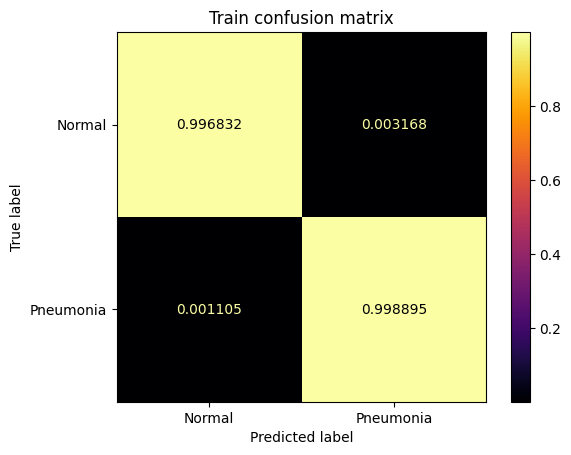

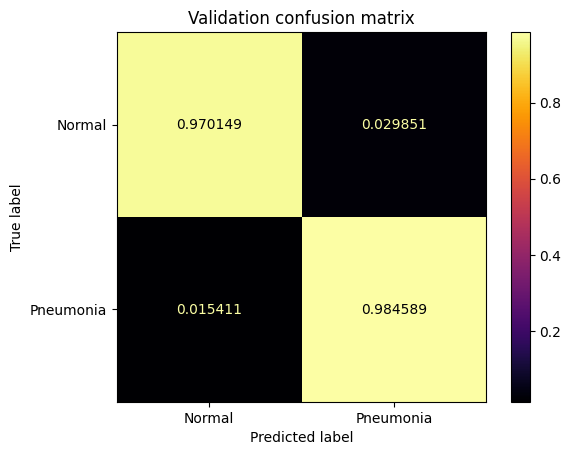

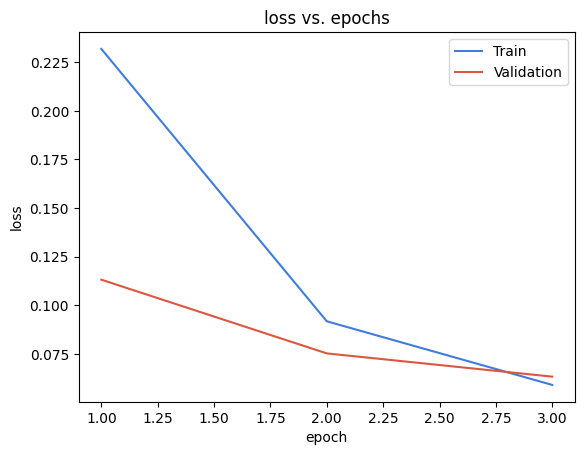

In [7]:
trainer.evaluate()
trainer.plot_loss()

In [8]:
model.set_history(trainer.get_history())

today = datetime.today().strftime("%Y_%m_%d")
torch.save(model.state_dict(), f"bin/{today}_model.pth")